In [2]:
# 3D extension of the countception network

In [3]:
import sys,os,time,random
import numpy as np

import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');

import tensorflow as tf

import skimage
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread, imsave
import pickle
import scipy

from os import walk

In [4]:
%matplotlib inline

In [5]:
# KERAS stuff 
from __future__ import print_function
import keras 

from keras import backend as K

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv3D, MaxPooling3D
from keras.layers.convolutional import ZeroPadding2D, ZeroPadding3D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Concatenate

from keras.models import load_model

In [6]:
print("keras", keras.__version__)
print("tensorflow", tf.__version__)

keras 2.0.6
tensorflow 1.3.0


In [7]:
# check the backend the ordering of the channels
print(keras.backend.backend())
print(keras.backend.image_dim_ordering())
print(K.image_data_format())

tensorflow
tf
channels_last


In [8]:
# Setup for the gpu: 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/gpu:0']

In [9]:
# check the output of the command above
tf.device("/gpu:0")
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# this pone should help with the images of the large size
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.80

In [10]:
# this part is necessary to set the params from the command line
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['']
    
parser = argparse.ArgumentParser(description='Count-ception')

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-nsamples', type=int, nargs='?',default=32, help='Number of samples (N) in train and valid')
# TODO: Is it used ? 
parser.add_argument('-stride', type=int, nargs='?',default=1, help='The args.stride at the initial layer')
# TODO: Is it used ?
parser.add_argument('-lr', type=float, nargs='?',default=0.00005, help='This will set the learning rate ')
parser.add_argument('-kern', type=str, nargs='?',default="sq", help='This can be gaus or sq')
parser.add_argument('-cov', type=float, nargs='?',default=1, help='This is the covariance when kern=gaus')
parser.add_argument('-scale', type=int, nargs='?',default=1, help='Scale the input image and labels')
parser.add_argument('-data', type=str, nargs='?',default="cells", help='Dataset folder')
parser.add_argument('-framesize', type=int, nargs='?',default=256, help='Size of the images processed at once')

args = parser.parse_args()

In [12]:
# set the passed parameters here if you forgot them
args.framesize = 256
args.scale = 1
args.nsamples = 3

print(args)
print(keras.backend.image_data_format())

Namespace(cov=1, data='cells', framesize=256, kern='sq', lr=5e-05, nsamples=3, scale=1, seed=0, stride=1)
channels_last


In [14]:
# how much to extend the initial image 
patch_size_w = int(16)
patch_size_h = int(16)
patch_size_d = int(16) # in the real example this one should be 8
framesize = int(args.framesize/args.scale)
channels = int(1)
framesize_h = int(256)
framesize_w = int(256)
framesize_d = int(27) # in the real example this one should be 27
noutputs = 1

In [15]:
paramfilename = str(args.scale) + "-" + str(patch_size_w) + "-" + args.data + "-" + args.kern + str(args.cov) + "_params.p"
datasetfilename = str(args.scale) + "-" + str(patch_size_w) + "-" + str(framesize) + "-" + args.kern + str(args.stride) + "-" + args.data + "-" + str(args.cov) + "-dataset.p"
print(paramfilename)
print(datasetfilename)

1-16-cells-sq1_params.p
1-16-256-sq1-cells-1-dataset.p


In [16]:
#reproducibility
random.seed(args.seed)
np.random.seed(args.seed)
tf.set_random_seed(args.seed)

In [17]:
# input shape is the image shape without the pathces
input_shape = (framesize_w, framesize_h, framesize_d, channels)

In [18]:
# check the input dimensions for the network
[x + y for x, y in zip(input_shape[0:3], (patch_size_w, patch_size_h, patch_size_d))]

[272, 272, 43]

In [19]:
# custom loss funciton
def mae_loss(y_true, y_pred):
    # mae_loss might be too "greedy" and train the network on artifacts
    # prediction_count2 = np.sum(y_pred / ef)
    # mae_loss = K.sum(K.abs(prediction_count2 - (y_true/ef)))
    #Mean Absolute Error is computed between each count of the count map
    l1_loss = K.abs(y_pred - y_true)
    loss = K.mean(l1_loss)    
    return loss 

In [20]:
# custom layers (building blocks)
def ConvFactory1(data, num_filters, filter_size, stride=1, pad=(0, 0, 0), nonlinearity=LeakyReLU(alpha=0.3)):
    # data is the input tensor, leaky rely as a nonlinearity
    # the padding is done in the first layer automatically! 
    # no need to preprocess the data
    data = ZeroPadding3D(padding = pad, data_format=None, input_shape=input_shape)(data)
    data = Conv3D(filters = num_filters, kernel_size = (filter_size, filter_size, filter_size), kernel_initializer='glorot_uniform')(data)
    data = LeakyReLU(alpha=0.3)(data)
    data = BatchNormalization()(data)
    return data
    
def SimpleFactory1(data, ch_1x1, ch_3x3):
    # used for double layers 
    conv1x1 = ConvFactory1(data, filter_size=1, pad=0, num_filters=ch_1x1)
    conv3x3 = ConvFactory1(data, filter_size=3, pad=1, num_filters=ch_3x3) 
    concat = Concatenate()([conv1x1, conv3x3])
    return concat 

In [21]:
# TODO: check again?
def create_model(input_shape):
    main_input = Input(shape=input_shape, name='main_input')
    # print (net.shape)
    net = ConvFactory1(main_input, num_filters=64, pad=(patch_size_w, patch_size_h, patch_size_d), filter_size = 3)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 16, ch_3x3 = 16)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 16, ch_3x3 = 32)
    print (net.shape)
    net = ConvFactory1(net, num_filters=16, filter_size = 14)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 112, ch_3x3 = 48)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 40, ch_3x3 = 40)
    print (net.shape)
    net = SimpleFactory1(net, ch_1x1 = 32, ch_3x3 = 96)
    print (net.shape)

    net = ConvFactory1(net, num_filters=16, filter_size = 18)
    print (net.shape) 
    net = ConvFactory1(net, num_filters=64, filter_size = 1)
    print (net.shape) 
    net = ConvFactory1(net, num_filters=64, filter_size = 1)
    print (net.shape) 
    main_output = ConvFactory1(net, filter_size=1, num_filters=1)
    print (main_output.shape)
    
    model = Model(inputs=[main_input], outputs = main_output)  
    # mean_absolute_error
    model.compile(loss=mae_loss, optimizer='sgd', metrics=['accuracy'])
         
    return model

In [22]:
model = create_model(input_shape = input_shape)
# model.summary()

(?, 286, 286, 57, 64)
(?, 286, 286, 57, 32)
(?, 286, 286, 57, 48)
(?, 273, 273, 44, 16)
(?, 273, 273, 44, 160)
(?, 273, 273, 44, 80)
(?, 273, 273, 44, 128)
(?, 256, 256, 27, 16)
(?, 256, 256, 27, 64)
(?, 256, 256, 27, 64)
(?, 256, 256, 27, 1)


In [23]:
#sanity check
print("network output size should be", [x + y for x, y in zip(input_shape[0:3], (patch_size_w, patch_size_h, patch_size_d))])

network output size should be [272, 272, 43]


In [24]:
# TODO: FIX THE EF COEFFICINT FOR THE CASE OF CUBE 
if (args.kern == "sq"):
    ef = ((patch_size_w/args.stride)**3.0)
elif (args.kern == "gaus"):
    ef = 1.0
print("ef", ef)

ef 4096.0


In [25]:
# test run
train_start_time = time.time()
# model.fit(np.zeros([1, input_shape[0], input_shape[1], input_shape[2], input_shape[3]]), 
#          np.zeros([1, input_shape[0] + patch_size_w, input_shape[1] + patch_size_h, input_shape[2] + patch_size_d, 1]))
print(time.time() - train_start_time, "sec")

train_start_time = time.time()
# model.predict();
print(time.time() - train_start_time, "sec")

8.153915405273438e-05 sec
7.772445678710938e-05 sec


In [28]:
# fucntions to see the results 
def genGausImage(framesize, mx, my, mz, cov=1):  
    framesize_x = framesize[0]
    framesize_y = framesize[1]
    framesize_z = framesize[2]
    
    x, y, z = np.mgrid[0:framesize_x, 0:framesize_y, 0:framesize_z]
    pos = np.dstack((x, y, z))
    mean = [mx, my, mz]
    cov = [[cov, 0, 0], [0, cov, 0], [0, 0, cov]]
    rv = scipy.stats.multivariate_normal(mean, cov).pdf(pos)
    return rv/rv.sum()

# TODO: FIX!
def getDensity(width, markers):
    gaus_img = np.zeros((width,width))
    for k in range(width):
        for l in range(width):
            if (markers[k,l] > 0.5):
                gaus_img += genGausImage(len(markers),k-patch_size/2,l-patch_size/2,cov)
    return gaus_img

def getMarkersCells(labelPath, scale, size):  
    labs = imread(labelPath).transpose([1,2,0])
    if len(labs.shape) == 3:
        lab = labs[:,:,:]/255
    elif len(labs.shape) == 4:
        lab = labs[:,:,:,0]/255
    else:
        print("unknown label format")
    
    binsize = [scale, scale, scale]
    out = np.zeros(size)    
    for i in range(binsize[0]):
        for j in range(binsize[1]):
            for k in range(binsize[2]):
                out = np.maximum(lab[i::binsize[0], j::binsize[1], k::binsize[2]], out)
        
    print(lab.sum(),out.sum())
    assert np.allclose(lab.sum(),out.sum(), 1)
    
    return out

def getCellCountCells(markers, x, y, z, h, w, d):
    types = [0] * noutputs
    for i in range(noutputs):
        types[i] = (markers[y:y+h,x:x+w, z:z+w] == 1).sum()
        #types[i] = (markers[y:y+h,x:x+w] != -1).sum()
    return types

def getLabelsCells(markers, img_pad, base_x, base_y, base_z, stride, scale):
    
    height = int ((img_pad.shape[0])/args.stride)
    width = int ((img_pad.shape[1])/args.stride)
    depth = int ((img_pad.shape[2])/args.stride)
    print("label size: ", height, width, depth)
    labels = np.zeros((noutputs, height, width, depth))
    if (args.kern == "sq"):
        for y in range(0,height):
            for x in range(0,width):
                for z in range(0, depth):
                    count = getCellCountCells(markers, x*args.stride, y*args.stride, z*args.stride, patch_size_w, patch_size_h, patch_size_d)  
                    for i in range(0,noutputs):
                        labels[i][y][x][z] = count[i]

    
    elif (args.kern == "gaus"):
        # gauss is not checked in 3D
        for i in range(0,noutputs):
            labels[i] = getDensity(width, markers[base_y:base_y+width,base_x:base_x+width, base_z:base_z+depth])
    
    
    print("getLabelsCells: DONE!")
    
    count_total = getCellCountCells(markers, 0, 0, 0, framesize_h+patch_size_h, framesize_w+patch_size_w, framesize_d+patch_size_d)
    return labels, count_total

def getTrainingExampleCells(img_raw, framesize_w, framesize_h, framesize_d, labelPath, base_x,  base_y, base_z, stride, scale):
    
    img = img_raw[base_y:base_y+framesize_h, base_x:base_x+framesize_w, base_z:base_z+framesize_d]
    img_pad = np.pad(img[:,:,:], ((int ((patch_size_w)/2), int ((patch_size_w)/2)), 
                                     (int ((patch_size_h)/2), int ((patch_size_h)/2)), 
                                     (int ((patch_size_d)/2), int ((patch_size_d)/2))), "constant")
    
    markers = getMarkersCells(labelPath, scale, img_raw.shape[0:3])
    markers = markers[base_y:base_y+framesize_h, base_x:base_x+framesize_w, base_z:base_z+framesize_d]
    markers = np.pad(markers, ((patch_size_w, patch_size_w), 
                               (patch_size_h, patch_size_h), 
                               (patch_size_d, patch_size_d)), "constant", constant_values=-1)
    
    labels, count  = getLabelsCells(markers, img_pad, base_x, base_y, base_z, args.stride, scale)
    return img, labels, count

In [29]:
# read the files from the test folder 
import glob

# prefix = '/Users/kkolyva/'
prefix = '/home/milkyklim/'
folder = prefix + 'dl-cell-counting/algorithm/data/test-cells-3D'
img_ext = '.tif'

print('Full path:', folder)

imgs = []

for filename in glob.iglob(folder + "/*dots" + img_ext):
    imgg = filename.replace("dots","cell")
    imgs.append([imgg,filename])
    
if len(imgs) == 0:
    print("Issue with dataset")
    sys.exit()

Full path: /home/milkyklim/dl-cell-counting/algorithm/data/test-cells-3D


In [ ]:
# code to debug the data generation
# adjust the size of the images and labels + check the output of the network
idx = 0
plt.rcParams['figure.figsize'] = (18, 9)
imgPath,labelPath,x,y,z = imgs[idx][0], imgs[idx][1], 0, 0, 0

print(imgPath)
print(labelPath)

im = imread(imgPath)
print(im.shape)


img_raw_raw = im.transpose([1,2,0]) #grayscale

# plt.imshow(img_raw_raw[:,:,1,:], interpolation='none',cmap='Greys_r');

print (img_raw_raw.shape[0], img_raw_raw.shape[1], img_raw_raw.shape[2])
# size_scaled = (int(img_raw_raw.shape[0]/args.scale), 
#                int(img_raw_raw.shape[1]/args.scale), 
#                int(img_raw_raw.shape[2]/args.scale), 1)

# print(size_scaled)
# img_raw = scipy.ndimage.zoom(img_raw_raw[:,:,:,:],size_scaled)
# img_raw = scipy.misc.imresize(img_raw_raw[:,:,:,:], size_scaled, mode='RGB')
img_raw = img_raw_raw
print(img_raw_raw.shape," ->>>>", img_raw.shape)

# plt.imshow(img_raw[:,:,1,:], interpolation='none',cmap='Greys_r');

print("img_raw", img_raw.shape)
img, lab, count = getTrainingExampleCells(img_raw, framesize_w, framesize_h, framesize_d, labelPath, x, y, z, args.stride, args.scale)
print("count", count)

markers = getMarkersCells(labelPath, args.scale, img_raw.shape[0:3])
markers = markers[y:y+framesize_h, x:x+framesize_w, z:z+framesize_d]
count = getCellCountCells(markers, 0, 0, 0, framesize_w,framesize_h, framesize_d)
print("count", count, 'markers max', markers.max())

# # pcount = model.predict(np.array([img]), batch_size=1)

lab_est = [(l.sum()/ef).astype(np.int) for l in lab]
# # pred_est = [(l.sum()/ef).astype(np.int) for l in pcount]

print("img shape",  img.shape)
print("label shape", lab.shape)
print("label est", lab_estgetTrainingExampleCells)
# print("label est ",lab_est," --> predicted est ",pred_est)

/home/milkyklim/dl-cell-counting/algorithm/data/test-cells-3D/002cell.tif
/home/milkyklim/dl-cell-counting/algorithm/data/test-cells-3D/002dots.tif
(27, 256, 256)
256 256 27
(256, 256, 27)  ->>>> (256, 256, 27)
img_raw (256, 256, 27)
13.0 13.0
label size:  288 288 59


In [30]:
# put some /show images/ here to see the result of processing

In [31]:
for path in imgs: 
    if (not os.path.isfile(path[0])):
        print(path, "bad", path[0])
    if (not os.path.isfile(path[1])):
        print(path, "bad", path[1])

In [32]:
dataset = []
if (os.path.isfile(datasetfilename)):
    print("reading", datasetfilename)
    dataset = pickle.load(open(datasetfilename, "rb" ))
else:
    dataset_x = []
    dataset_y = []
    dataset_c = []
    print(len(imgs))
    for path in imgs: 

        imgPath = path[0]
        print(imgPath)

        im = imread(imgPath)
        img_raw_raw = im.transpose([1,2,0])
        
        # img_raw = scipy.misc.imresize(img_raw_raw, (int(img_raw_raw.shape[0]/args.scale),int(img_raw_raw.shape[1]/args.scale)))
        img_raw = img_raw_raw
        print(img_raw_raw.shape," ->>>>", img_raw.shape)

        labelPath = path[1]
        for base_x in range(0,img_raw.shape[0],framesize_h):
            for base_y in range(0,img_raw.shape[1],framesize_w):
                for base_z in range(0,img_raw.shape[2],framesize_d):

                    if (img_raw.shape[1] - base_y < framesize_w) or (img_raw.shape[0] - base_x < framesize_h) or (img_raw.shape[2] - base_z < framesize_d):
                        print("!!!! Not adding image because size is" , img_raw.shape[1] - base_y, img_raw.shape[0] - base_x, img_raw.shape[2] - baze_z)
                        continue

                    img, lab, count = getTrainingExampleCells(img_raw, framesize_w, framesize_h, framesize_d, labelPath, base_y, base_x, base_z, args.stride, args.scale)
                    print("count ", count)

                    if img.shape[0:3] != (framesize_w,framesize_h, framesize_d):
                        print("!!!! Not adding image because size is" , img.shape[0:3])

                    else :   
                        lab_est = [(l.sum()/ef).astype(np.int) for l in lab]

                        print("lab_est ", lab_est)
                        
                        assert np.allclose(count,lab_est, 0)

                        dataset.append((img,lab,count))

                        print("lab_est", lab_est, "img shape", img.shape, "label shape", lab.shape)
                        sys.stdout.flush()
                    
        print("dataset size", len(dataset))
                    
    print("writing", datasetfilename)
    out = open(datasetfilename, "wb",0)
    pickle.dump(dataset, out)
    out.close()
print("DONE")

reading 1-16-256-sq1-cells-1-dataset.p
DONE


In [53]:
# grab the data from the data set
np.random.shuffle(dataset)

np_dataset_x = np.asarray([d[0] for d in dataset], dtype=np.float32)
np_dataset_y = np.asarray([d[1] for d in dataset], dtype=np.float32)
np_dataset_c = np.asarray([d[2] for d in dataset], dtype=np.float32)

np_dataset_x = np_dataset_x # .transpose((0,3,1,2))

print("np_dataset_x", np_dataset_x.shape)
print("np_dataset_y", np_dataset_y.shape)
print("np_dataset_c", np_dataset_c.shape)

np_dataset_x (3, 256, 256, 27)
np_dataset_y (3, 1, 272, 272, 43)
np_dataset_c (3, 1)


In [40]:
length = len(np_dataset_x)

# 2/3 vs 1/3 for training and validation
n = int (args.nsamples / 3); 

np_dataset_x_train = np_dataset_x[0:2*n]
np_dataset_y_train = np_dataset_y[0:2*n]
np_dataset_c_train = np_dataset_c[0:2*n]
print("np_dataset_x_train", len(np_dataset_x_train))

np_dataset_x_valid = np_dataset_x[2*n:3*n]
np_dataset_y_valid = np_dataset_y[2*n:3*n]
np_dataset_c_valid = np_dataset_c[2*n:3*n]
print("np_dataset_x_valid", len(np_dataset_x_valid))

np_dataset_x_test = np_dataset_x[3*n:]
np_dataset_y_test = np_dataset_y[3*n:]
np_dataset_c_test = np_dataset_c[3*n:]
print("np_dataset_x_test", len(np_dataset_x_test))

np_dataset_x_train 2
np_dataset_x_valid 1
np_dataset_x_test 0


In [44]:
length = len(np_dataset_x)

# 2/3 vs 1/3 for training and validation
n = 0 # int (args.nsamples / 3); 

np_dataset_x_train = np_dataset_x[0:1]
np_dataset_y_train = np_dataset_y[0:1]
np_dataset_c_train = np_dataset_c[0:1]
print("np_dataset_x_train", len(np_dataset_x_train))

np_dataset_x_valid = np_dataset_x[1:2]
np_dataset_y_valid = np_dataset_y[1:2]
np_dataset_c_valid = np_dataset_c[1:2]
print("np_dataset_x_valid", len(np_dataset_x_valid))

np_dataset_x_test = np_dataset_x[2:]
np_dataset_y_test = np_dataset_y[2:]
np_dataset_c_test = np_dataset_c[2:]
print("np_dataset_x_test", len(np_dataset_x_test))

np_dataset_x_train 1
np_dataset_x_valid 1
np_dataset_x_test 1


In [45]:
# some stats before the run
print("number of counts total ", np_dataset_c.sum())
print("number of counts on average ", np_dataset_c.mean(), "+-", np_dataset_c.std())
print("counts min:", np_dataset_c.min(), "max:", np_dataset_c.max())

number of counts total  39.0
number of counts on average  13.0 +- 0.0
counts min: 13.0 max: 13.0


In [ ]:
# examples of the images from the training set 
n_images_show = 7
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Example images")
plt.imshow(np.concatenate(np_dataset_x_train[:n_images_show].astype(np.uint8).transpose((0,2,3,1)),axis=1), interpolation='none');

In [ ]:
plt.title("Example images")
plt.imshow(np.concatenate(np_dataset_y_train[:n_images_show,0],axis=1), interpolation='none');

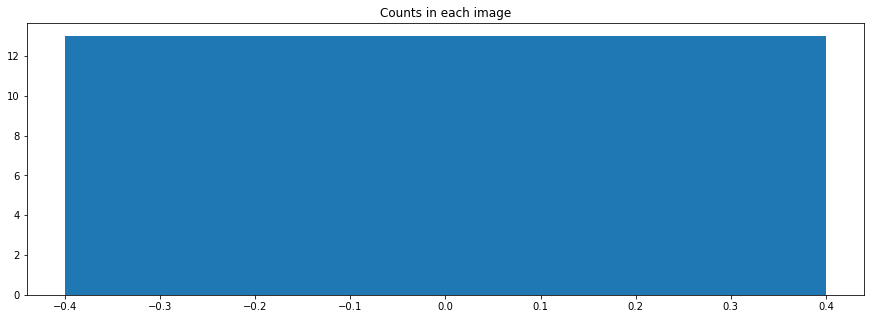

In [47]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Counts in each image")
plt.bar(range(len(np_dataset_c_train)),np_dataset_c_train);

In [48]:
# some stats again
print("Total cells in training", np.sum(np_dataset_c_train[0:], axis=0))
print("Total cells in validation", np.sum(np_dataset_c_valid[0:], axis=0))
print("Total cells in testing", np.sum(np_dataset_c_test[0:], axis=0))

Total cells in training [ 13.]
Total cells in validation [ 13.]
Total cells in testing [ 13.]


In [49]:
directory = "network-temp/"
model_ext = "-countception.h5py"

if not os.path.exists(directory):
    os.makedirs(directory)

def save_network(net, name):
    net.save(directory + str(name) + model_ext)
    
# pay attention to the loss function    
def load_network(name):
    return load_model(directory + str(name) + model_ext, custom_objects={'mae_loss': mae_loss})

In [52]:
num_epochs = 100
batch_size = 4

model.fit(np_dataset_x_train.transpose((0,2,3,1)), np_dataset_y_train.transpose((0,2,3,4, 1)),
          epochs = num_epochs,
          batch_size = batch_size,
          validation_data=(np_dataset_x_valid.transpose((0,2,3,1)), np_dataset_y_valid.transpose((0,2,3,4,1))))

ValueError: Error when checking input: expected main_input to have 5 dimensions, but got array with shape (1, 256, 256, 27)